In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using Support Vector Machines. and RBF Kernel

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Support Vector Machines to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset. 
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [31]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display some of the datapoints from the loaded dataset.
print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])
filtered_data.head(5)

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [32]:
#This code block check how many entries are there from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", connection_sqlobject)

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [33]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [34]:
display['COUNT(*)'].sum()

393063

In [35]:
#Checking the number of entries that came from UserId="AR5J8UI46CURR"
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection_sqlobject)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [36]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [37]:
#Sorting data according to Time in ascending order. The oldest reviews will be displayed at the top and the new reviews will be display at the end of the dataset.
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [38]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered_duplicates.shape))

The shape of the data matrix after deduplication, Stage 1: (364173, 12)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [40]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [41]:
#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication, Stage 2: : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Delete unwanted variables to free up memory space
del(filtered_duplicates, filtered_data, display, sorted_data)

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication, Stage 2: : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


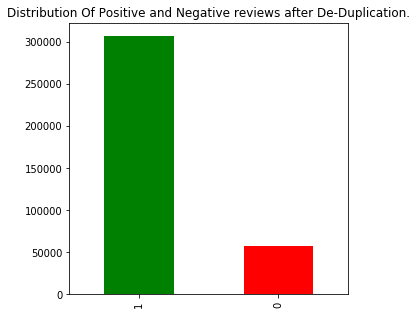

In [42]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
#Printing some random reviews from the deduplicated dataset.
sent_1 = final_data['Text'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Text'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Text'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Text'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Text'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)

sent_6 = final_data['Text'].values[255600]
print(sent_6)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[255600]))
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.
Review Polarity: Positive
At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My d

In [44]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)
sent_6 = re.sub(r"http\S+", " ", sent_6)

print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)
print(sent_6,"\n")
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful. 

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal. 

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again. 

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results. 

Excellent service, the product arri

In [45]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")
print(removeHtml(sent_6) + "\n")

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.  Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results.

Excellent service, the product arrived on time an

In [46]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [47]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.


In [73]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [49]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

<h2><font color='red'>[3.1] Preprocessing Review Text</font></h2>

100%|██████████| 70246/70246 [00:00<00:00, 797137.23it/s]


Text(0,0.5,'Number of Words')

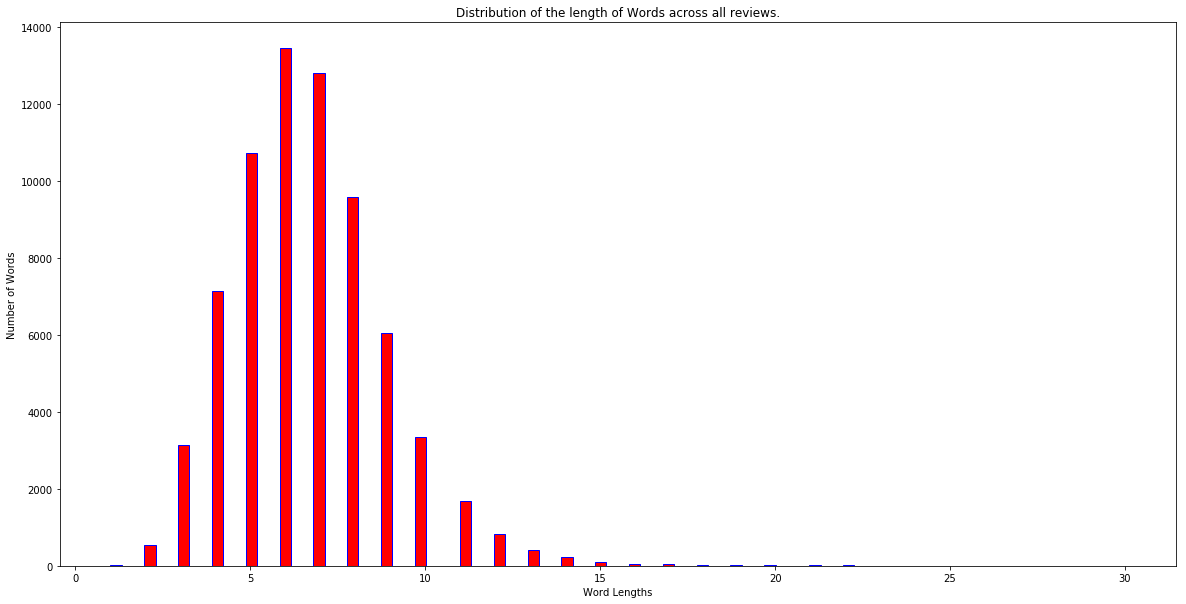

In [71]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram:
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [74]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|██████████| 364171/364171 [11:37<00:00, 521.74it/s]


The length of the data corpus is : 364171


<h2><font color='red'>[3.2] Preprocessing Review Summary + Saving the Processed DB for future use.</font></h2>

In [79]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

File is saved as 'totally_processed_DB.sqlite'


# Applying SVM with RBF Kernel

The below block of code contains all the common functions that are used for the evaluation of the models.

In [7]:
#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization, hyp):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C or alpha values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i][hyp])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs Hyperparameter values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('AUC Scores vs Hyperparameter Values ')
    plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
    plt.ylabel('(AUC Scores)')
    plt.legend()
    plt.show()
    
    if(regularization=='l2'):
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:40] , auc_train[0:40], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:40] , auc_test[0:40], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    else:
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:25] , auc_train[0:25], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:25] , auc_test[0:25], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    
    return (optimal_hp)

#Fit this model with the best value of hyperparameter obtained.
def performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and train the model.
    classifier = best_clf
    classifier.fit(X_train, y_train)

    #Using CalibratedClassifierCV to caliberate the model and plot the ROC AUC Curve.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)
    
    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)
    
    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix ")
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_SVMRBF.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return calibrated_clf

## [5.2] RBF SVM

In [26]:
def get_GridSearchCV_estimator_RBF_SVM(regularization, vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUsing {} regularization for {} model!".format(regularization, vectorizationType))
    print("*****************************************************")
    from sklearn.model_selection import KFold
    from datetime import datetime as dt
    st=dt.now()
    from sklearn.svm import SVC
    
    C_hyp = np.logspace(-4,4,10)
    gamma = np.logspace(-4,4,10)
    tuned_parameters = [{'C': C_hyp,
                         'gamma': gamma}]#alpha values used for cross validation
    cv_timeSeries = KFold(n_splits=5).split(X_train)
    
    base_estimator = SVC(kernel='rbf', random_state=0)
    gsearch_cv = GridSearchCV(estimator=base_estimator, param_grid=tuned_parameters, cv=cv_timeSeries, scoring='roc_auc', n_jobs=8)
    gsearch_cv.fit(X_train, y_train)
    
    print("\nTime taken to complete grid search: ",dt.now()-st)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_c=plot_errors(gsearch_cv, regularization, 'C')
    optimal_gamma=plot_errors(gsearch_cv, regularization, 'gamma')
    
    return  (gsearch_cv,optimal_c) 

def RBF_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. ".format(regularization.upper()))
    print("********************************************************************************")
    gsearch_cv, optimal_c = get_GridSearchCV_estimator_RBF_SVM(regularization, vectorizationType, X_train, y_train, X_test, y_test)
    best_clf = gsearch_cv.best_estimator_
    
    #Calibrate the best estimator on a disjoint calibration dataset.
    trained_classifier = performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_c)
    
    return (trained_classifier)

## Taking 20K balanced data points for training, 5000 for testing and 5000 for calibrating classifiers.

In [23]:
'''Loading the Amazon dataset, Remove duplicate data.'''
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Here we are balancing the dataset by taking the number of positive reviews to be equal to the number of negative reviews, since negative reviews was the class with much lesser datapoints.
#https://stackoverflow.com/questions/45839316/pandas-balancing-data
g = processed_db.groupby('Class_Labels')
df=g.apply(lambda x: x.sample(g.size().min(), random_state=42))
df = df.sample(n=30000, random_state=0)
df['Class_Labels'].value_counts()

#Split the data set into train and test sets and calibration sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 20000 data will get into the train set. The older 5000 data will go into the test set. The newest 5000 data will get into the calibration dataset.
X_train = df['Combined_Reviews'][0:20000,] ; y_train = df['Class_Labels'][0:20000,]
X_test = df['Combined_Reviews'][20000:25000,] ; y_test = df['Class_Labels'][20000:25000,]
X_calib = df['Combined_Reviews'][25000:,] ; y_calib = df['Class_Labels'][25000:,]

print("Number of data-points in the training sample: ",X_train.shape[0])
print("Number of data-points in the test sample: ",X_test.shape[0])

df.head()

Number of data-points in the training sample:  20000
Number of data-points in the test sample:  5000


index      Id   ProductId          UserId  \
Class_Labels                                                      
0            324068  163992  177867  B001ELL4YA   AAD53V45KF2VL   
1            93652   186174  201923  B0038AM3W2  A3M0RV8G7XHDH0   
             76694    58269   63207  B006BXUVPY   A96K1ZGW56S2I   
             251713  162892  176606  B000NKFX54  A20MPLRATY60K4   
0            224873  418334  452396  B001E5DYUI   AYFCMX6EMIPKE   

                                                   ProfileName  \
Class_Labels                                                     
0            324068  Kerry T. Givens "One out of five doctors"   
1            93652                                    K. Brown   
             76694                               tvtv3 "tvtv3"   
             251713                               granny smith   
0            224873                                      Scott   

                     HelpfulnessNumerator  HelpfulnessDenominator  Score  \
Class_Labels                                                               
0            324068                     0                       3      2   
1            93652                      0                       0      5   
             76694                      0                       0      4   
             251713                     0                       0      5   
0            224873                     1                       1      2   

                           Time  \
Class_Labels                      
0            324068  1227657600   
1            93652   1332374400   
             76694   1336176000   
             251713  1284681600   
0            224873  1296518400   

                                                               Summary  \
Class_Labels                                                             
0            324068               Look like jets...taste like jet fuel   
1            93652                                       Great Popcorn   
             76694                                 Something Different   
             251713                                  Best suckers ever   
0            224873  good but not at this price or even half this p...   

                                                                  Text  \
Class_Labels                                                             
0            324068  I guess I have developed somewhat rarified tas...   
1            93652   This is great popcorn.  Orginally ordered for ...   
             76694   I enjoy CHEEZ-IT crackers. However, now instea...   
             251713  Best box of suckers ever!  Love the classic fl...   
0            224873  Crazy !  Lavazza is just as good for way less....   

                    SentimentPolarity  Class_Labels  \
Class_Labels                                          
0            324068          Negative             0   
1            93652           Positive             1   
             76694           Positive             1   
             251713          Positive             1   
0            224873          Negative             0   

                                                           CleanedText  \
Class_Labels                                                             
0            324068  guess develop somewhat rarifi tast gummi candi...   
1            93652   great popcorn orgin order movi night love much...   
             76694   enjoy cheez cracker howev instead regular ched...   
             251713  best box sucker ever love classic flavor count...   
0            224873  crazi lavazza good way less price coffe good n...   

                                                   CleanedSummary  \
Class_Labels                                                        
0            324068              look like jet tast like jet fuel   
1            93652                                  great popcorn   
             76694                                  someth differ   
             251713   

Positive    15081
Negative    14919
Name: SentimentPolarity, dtype: int64


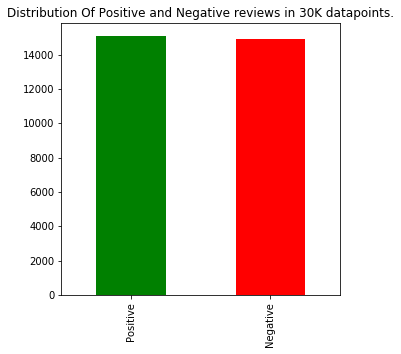

In [24]:
#Get number of postive and negative review samples
print(df["SentimentPolarity"].value_counts())

#Display distribution of Postive and Negative reviews in a bar graph
df["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 30K datapoints.',figsize=(5,5))

As we can see, the data is well balanced. So we would expect a similar precision and recall values for both the postive as well the negative classes. Let's build some models now! We will take the top most 1000 relevant features while trying to build our models.

### [5.2.1] Applying RBF SVM on BOW + L1 Regularization,<font color='red'> SET 1</font>

Some feature names  ['everyth', 'exact', 'excel', 'excit', 'expect', 'expens', 'experi', 'expir', 'extra', 'extrem']

Creating the BOW vectors using the cleaned corpus...
Shape of the train data matrix:  (20000, 500)
Shape of the test data matrix:  (5000, 500)
Shape of the calibration data matrix:  (5000, 500)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The number of unique words  500

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for BOW-RBF-SVM model!
*****************************************************
Best estimator for l1 regularization : 
 SVC(C=2.782559402207126, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.000774263682681127,
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)
Best Score for l1 regularization :

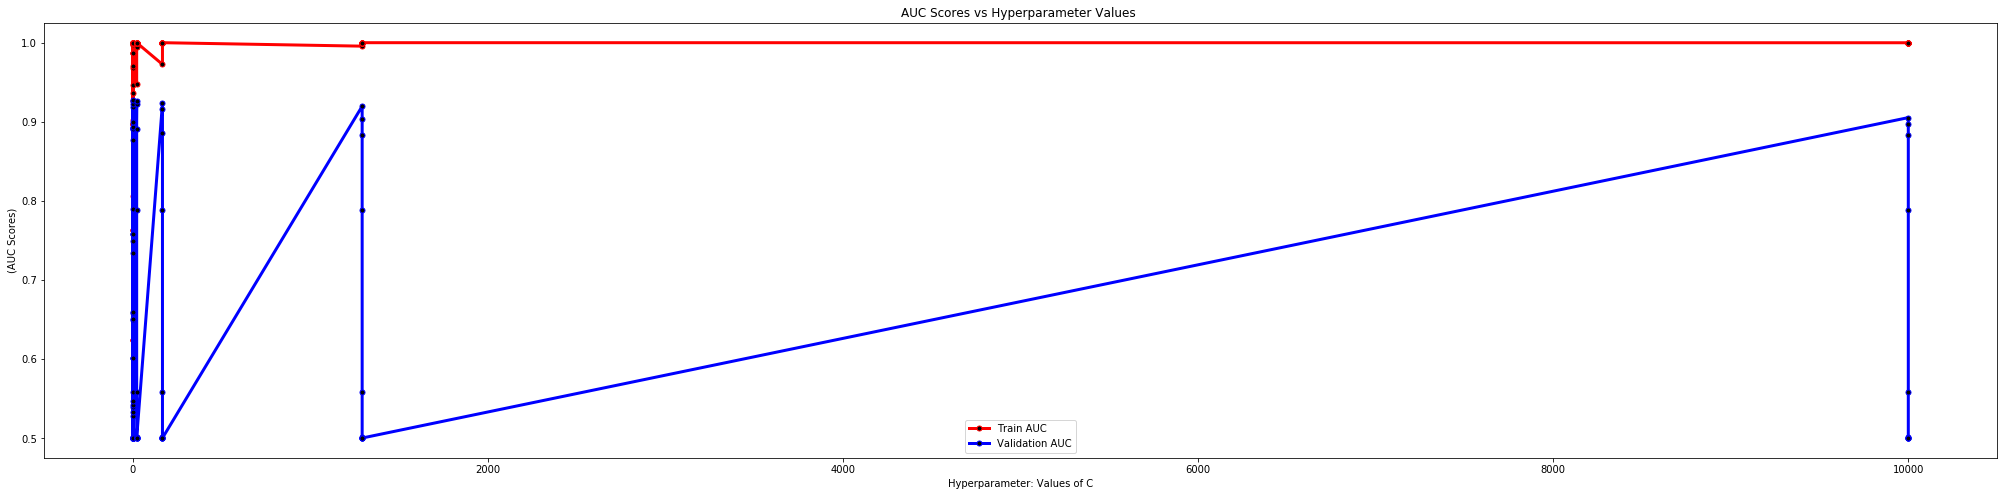

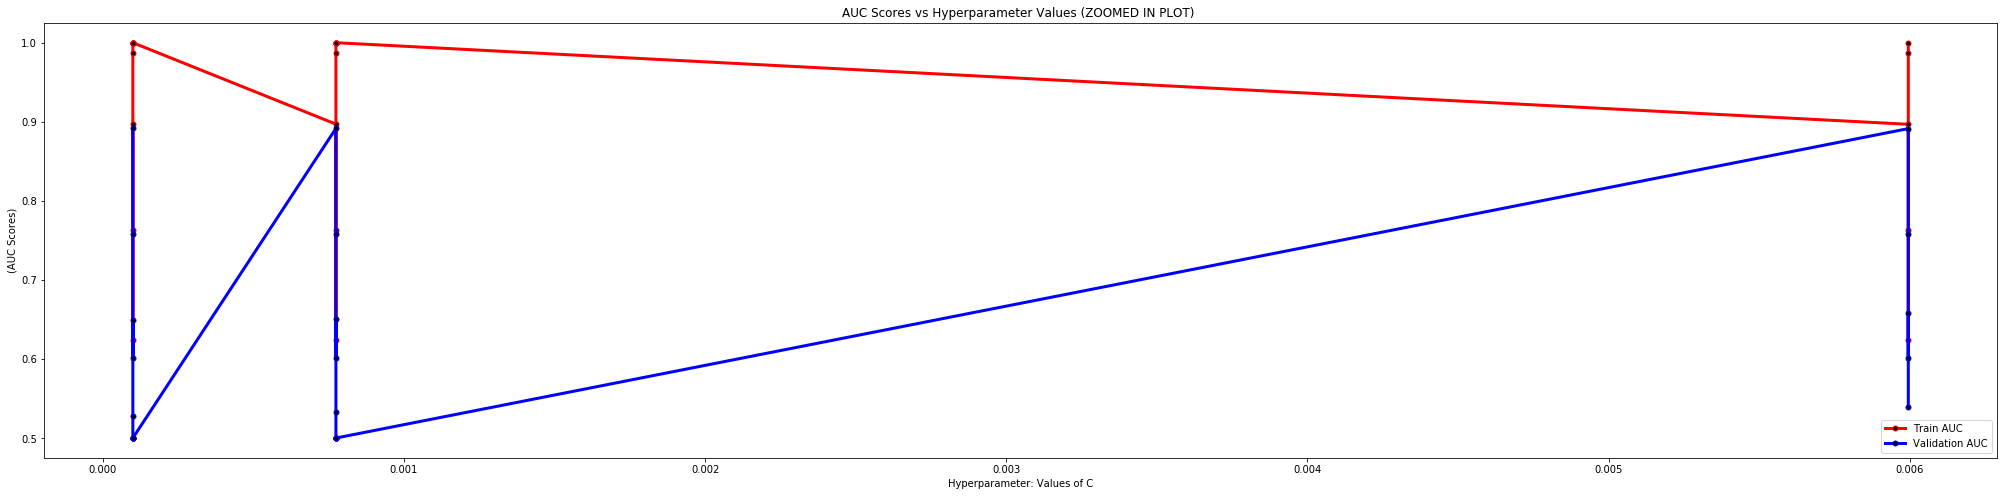

The optimal value of C using l1 regularization is : 0.000774263682681127


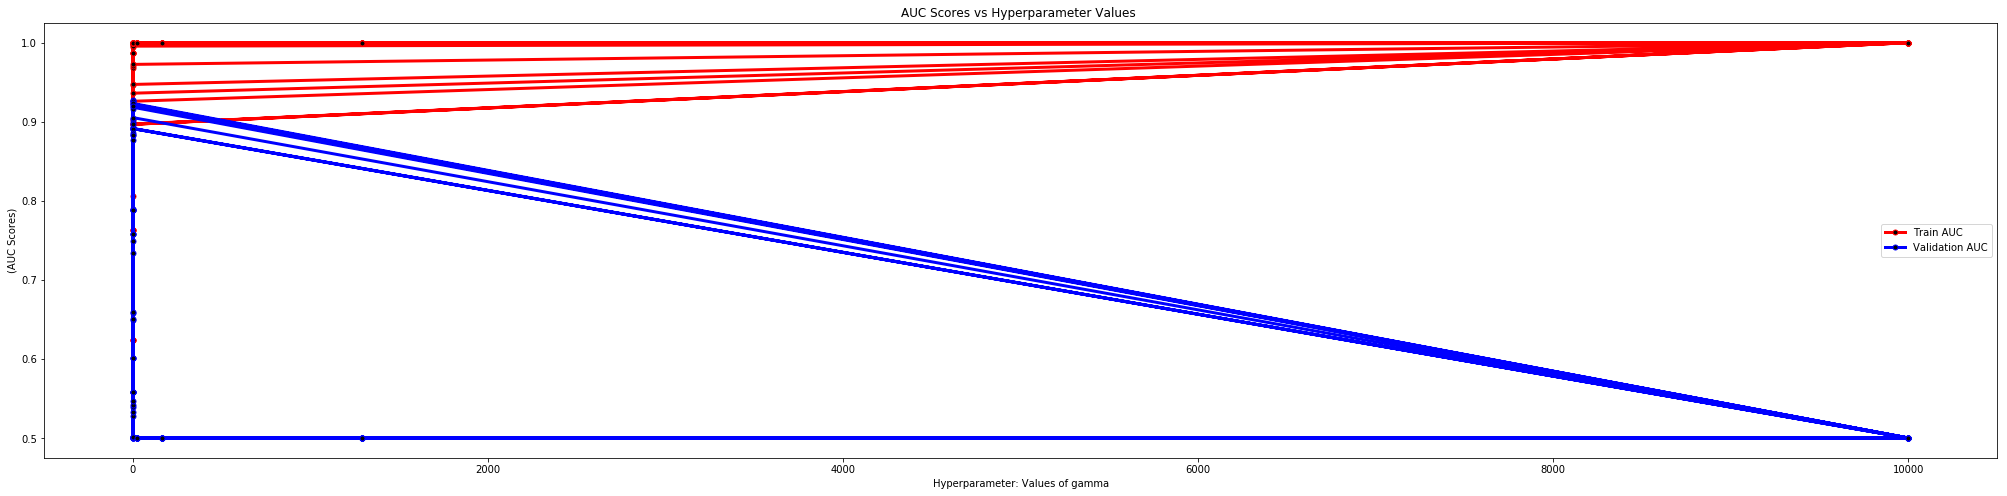

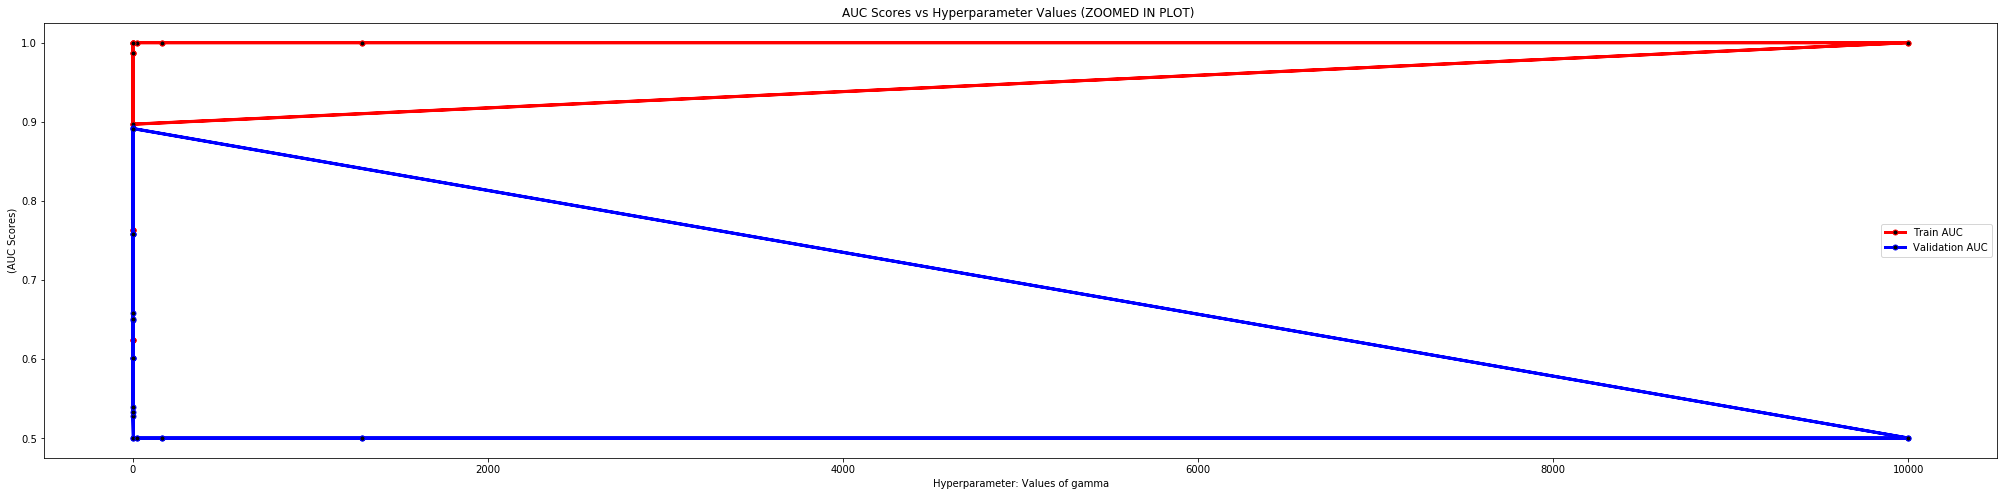


'''PERFORMANCE EVALUATION for BOW-RBF-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 5000 data points on unseen data for l1 regularization is 4255
Accuracy of the BOW-RBF-SVM model using l1 regularization on unseen data is 85.1 %
Precision of the BOW-RBF-SVM model using l1 regularization on unseen data is 0.8576
Recall of the BOW-RBF-SVM model using l1 regularization on unseen data is 0.8408
F1 score of the BOW-RBF-SVM model using l1 regularization on unseen data is 0.8491
AUC of the BOW-RBF-SVM model using l1 regularization on unseen data is 0.9286

Clasification report 
             precision    recall  f1-score   support

          0       0.84      0.86      0.85      2507
          1       0.86      0.84      0.85      2493

avg / total       0.85      0.85      0.85      5000


Of all the reviews that the model has predicted to be positive, 86.0% of them are actually positive.
Of all

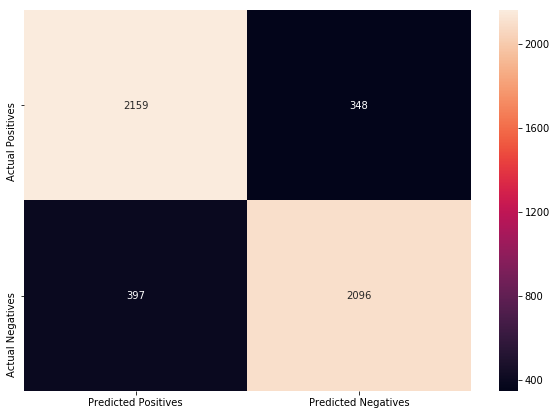

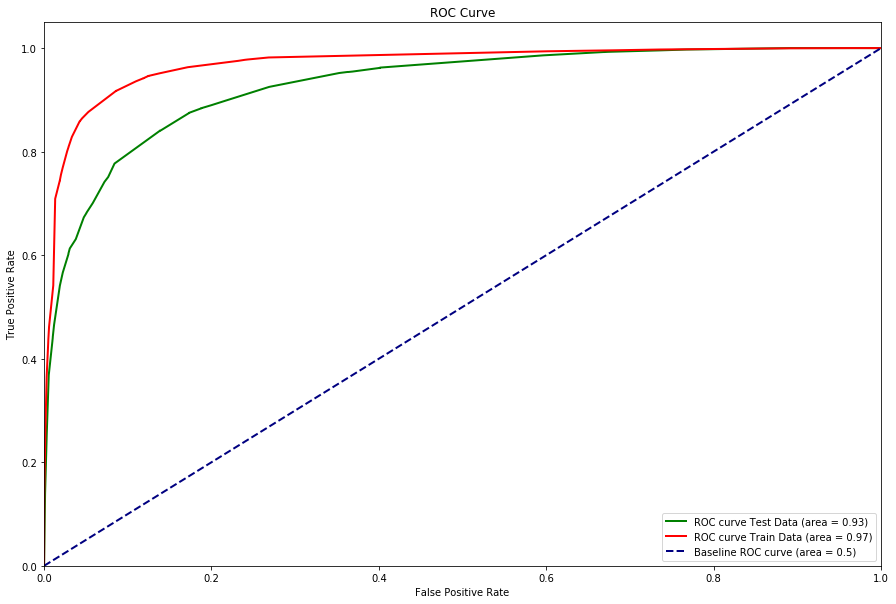

In [8]:
#Initializing the BOW constructor
cv_object = CountVectorizer(min_df=10, max_features=500, dtype='float').fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[150:160])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")

X_train_vec = cv_object.transform(X_train)
X_test_vec = cv_object.transform(X_test)
X_calib_vec = cv_object.transform(X_calib)

X_train_std = standardize(X_train_vec)
X_test_std = standardize(X_test_vec)
X_calib_std = standardize(X_calib_vec)

print("Shape of the train data matrix: ",X_train_std.shape)
print("Shape of the test data matrix: ",X_test_std.shape)
print("Shape of the calibration data matrix: ",X_calib_std.shape)

print("\nThe type of count vectorizer ",type(X_train_vec))
print("The number of unique words ", X_train_std.get_shape()[1])

trained_classifier_RBF_BOW = RBF_SVM(X_train_std, y_train, X_test_std, y_test, X_calib_std, y_calib, 'l1', "BOW-RBF-SVM")

### [5.2.2] Applying RBF SVM on TFIDF + L1 Regularization,<font color='red'> SET 2</font>

Some feature names  ['expect', 'expens', 'experi', 'expir', 'extra', 'extrem', 'fact', 'fair', 'famili', 'fan']

Creating the TFIDF vectors using the cleaned corpus...
Shape of the train data matrix:  (20000, 500)
Shape of the test data matrix:  (5000, 500)
Shape of the calibration data matrix:  (5000, 500)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The number of unique words  500

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-RBF-SVM model!
*****************************************************
Best estimator for l1 regularization : 
 SVC(C=166.81005372000558, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Best Score for l1 regularization :  0.9284747218

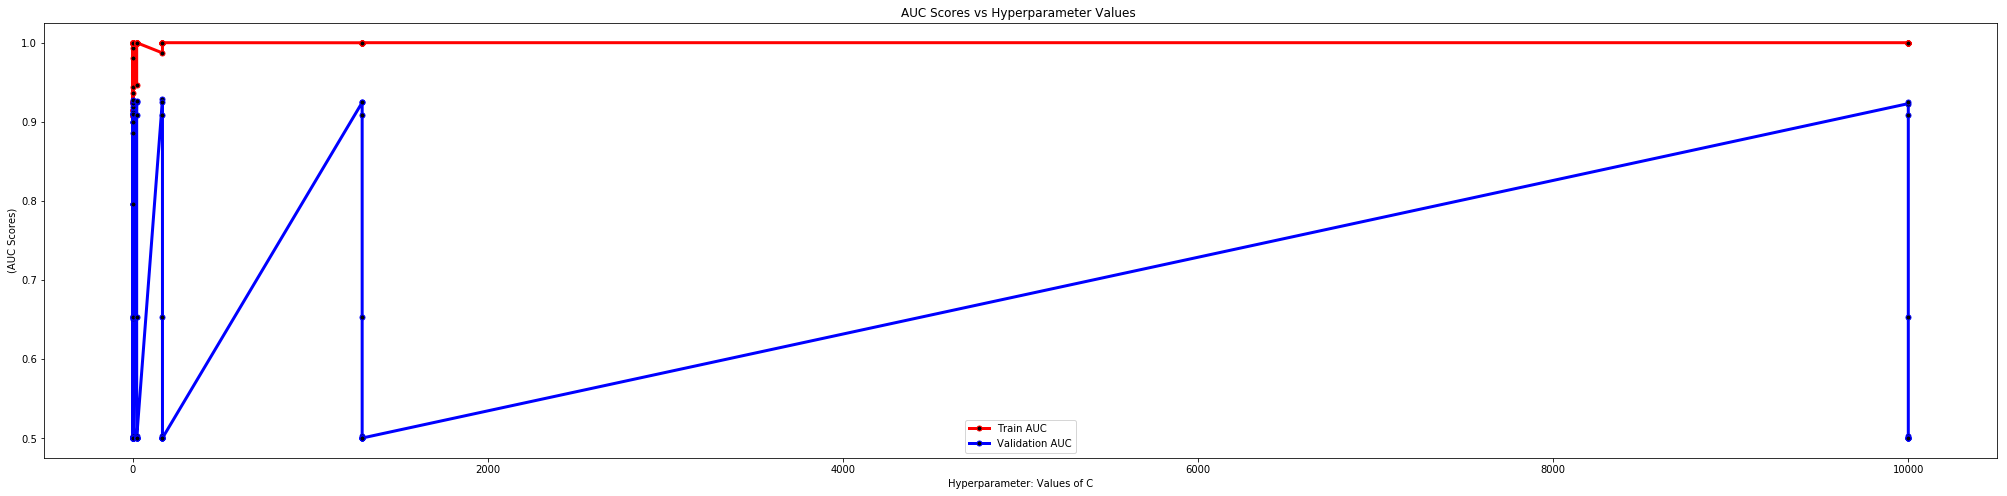

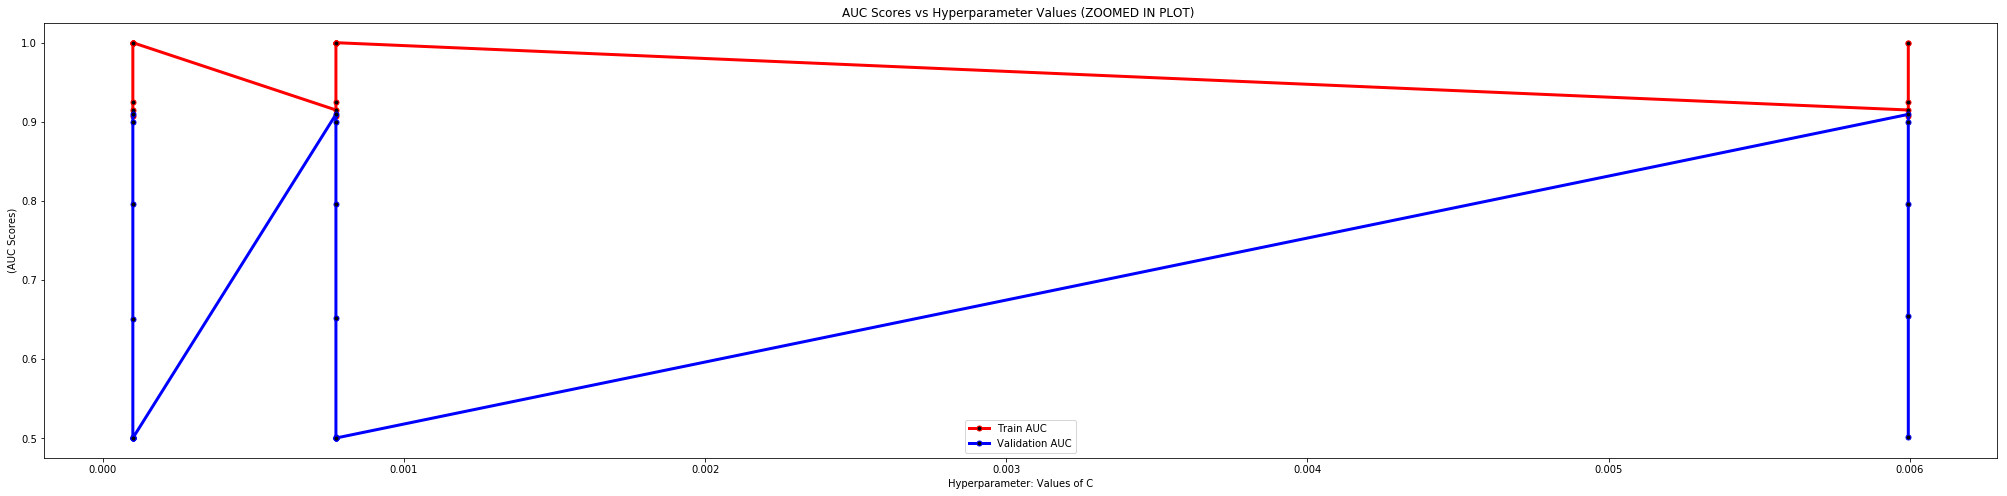

The optimal value of C using l1 regularization is : 0.0001


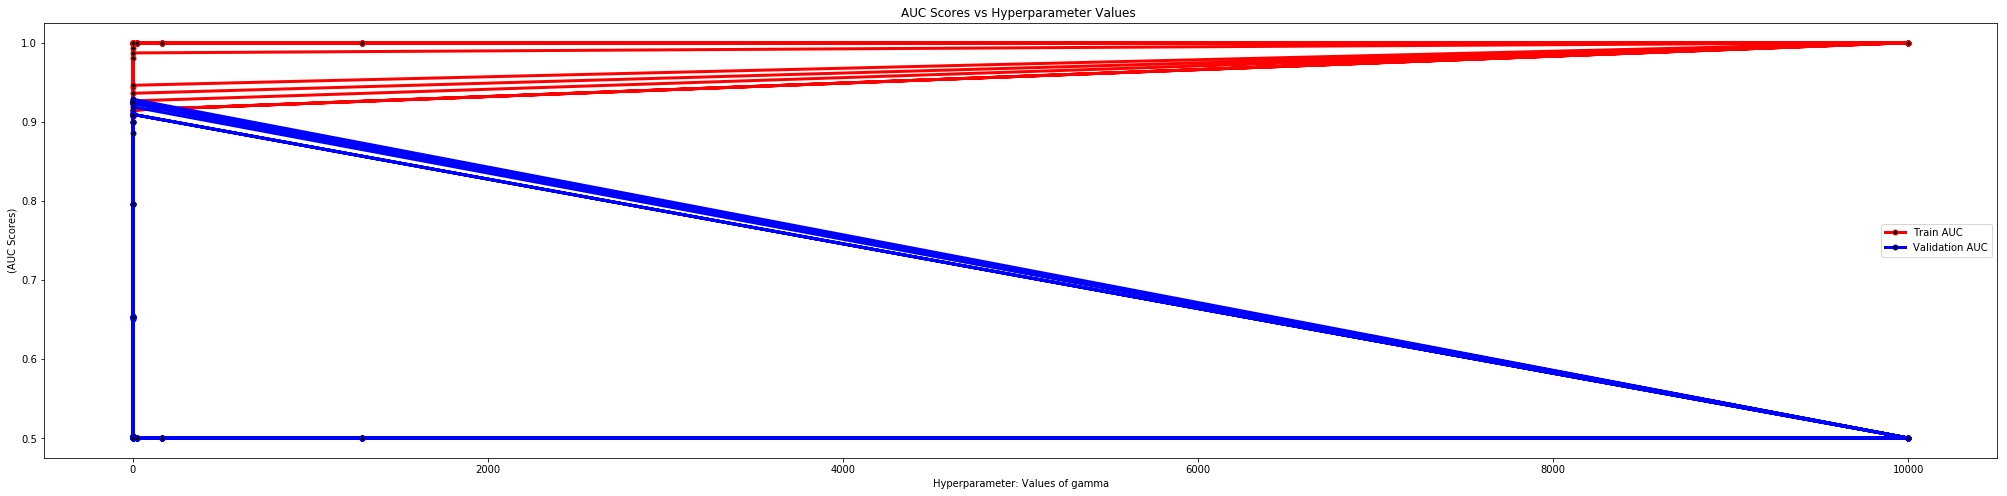

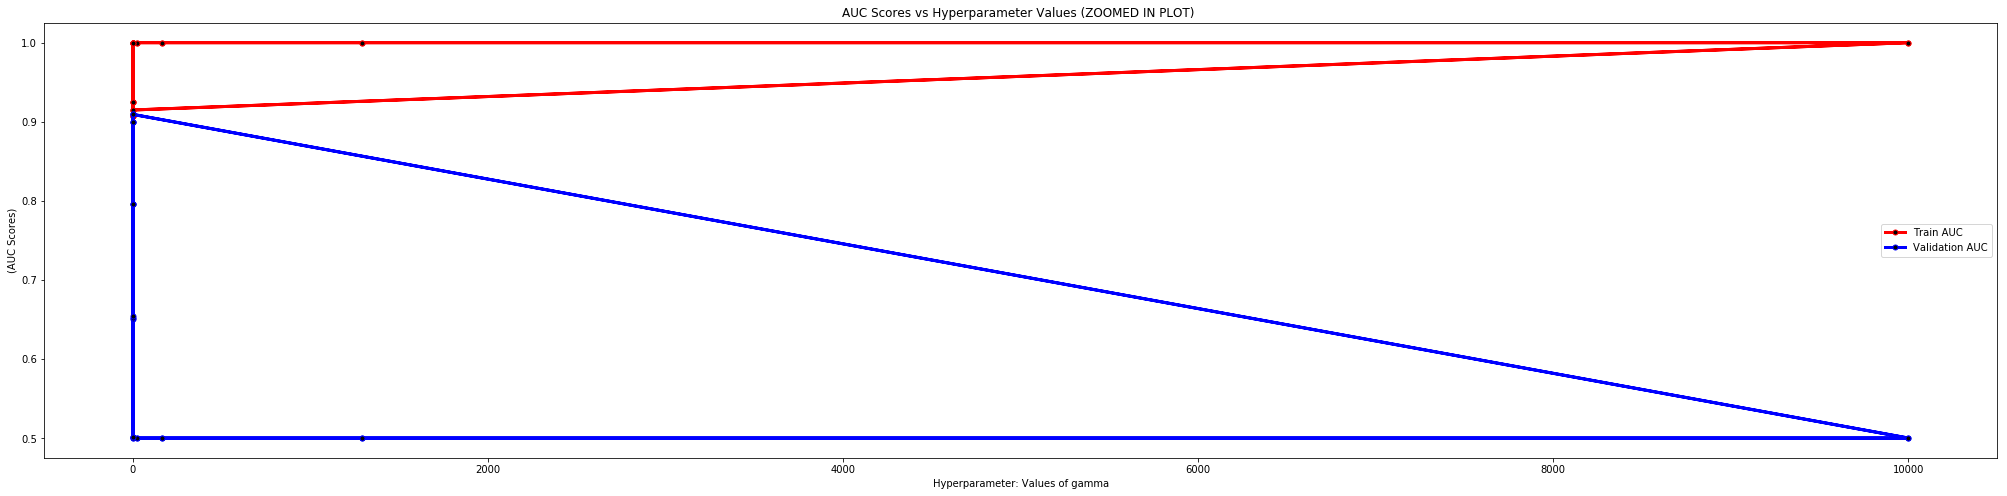


'''PERFORMANCE EVALUATION for TFIDF-RBF-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 5000 data points on unseen data for l1 regularization is 4295
Accuracy of the TFIDF-RBF-SVM model using l1 regularization on unseen data is 85.9 %
Precision of the TFIDF-RBF-SVM model using l1 regularization on unseen data is 0.8527
Recall of the TFIDF-RBF-SVM model using l1 regularization on unseen data is 0.8726
F1 score of the TFIDF-RBF-SVM model using l1 regularization on unseen data is 0.8625
AUC of the TFIDF-RBF-SVM model using l1 regularization on unseen data is 0.9346

Clasification report 
             precision    recall  f1-score   support

          0       0.87      0.85      0.86      2465
          1       0.85      0.87      0.86      2535

avg / total       0.86      0.86      0.86      5000


Of all the reviews that the model has predicted to be positive, 85.0% of them are actually posi

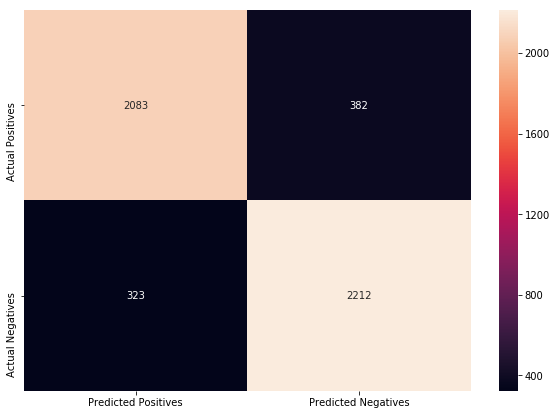

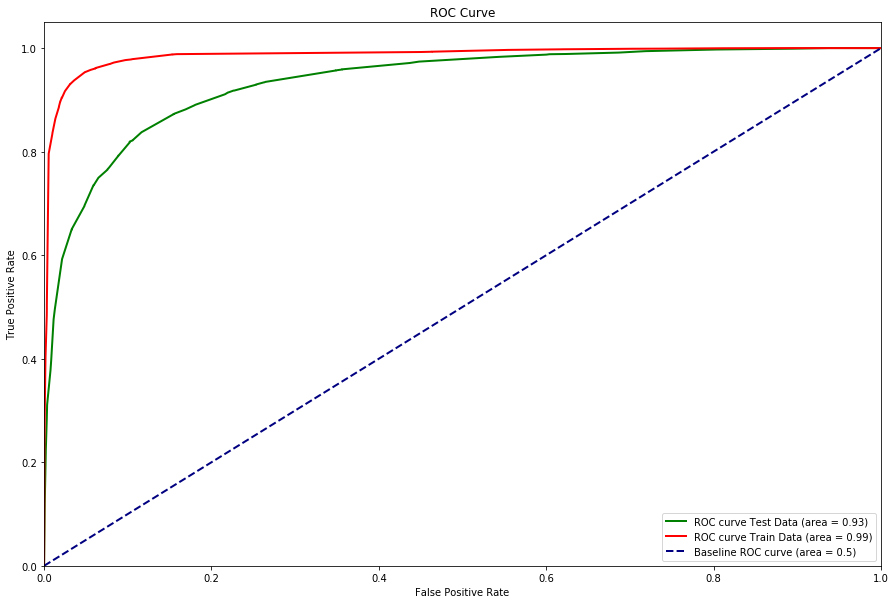

In [7]:
#Initializing the TFIDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,1), min_df=10, max_features=1000, dtype='float').fit(X_train)

#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[150:160])
print('='*215)

#Creating the TFIDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TFIDF vectors using the cleaned corpus...")
X_train_vec = tf_idf_obj.transform(X_train)
X_test_vec = tf_idf_obj.transform(X_test)
X_calib_vec = tf_idf_obj.transform(X_calib)

X_train_std = standardize(X_train_vec)
X_test_std = standardize(X_test_vec)
X_calib_std = standardize(X_calib_vec)

print("Shape of the train data matrix: ",X_train_std.shape)
print("Shape of the test data matrix: ",X_test_std.shape)
print("Shape of the calibration data matrix: ",X_calib_std.shape)

print("\nThe type of count vectorizer ",type(X_train_vec))
print("The number of unique words ", X_train_vec.get_shape()[1])

trained_classifier_RBF_TFIDF = RBF_SVM(X_train_std, y_train, X_test_std, y_test, X_calib_std, y_calib, 'l1', "TFIDF-RBF-SVM")

### [5.2.3]  Applying RBF SVM on AVG W2V + L1 Regularization,<font color='red'> SET 3</font>

100%|██████████| 5000/5000 [00:06<00:00, 795.01it/s]



USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for AVG-W2V-RBF-SVM model!
*****************************************************
Best estimator for l1 regularization : 
 SVC(C=166.81005372000558, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Best Score for l1 regularization :  0.9284747218734499
The optimal value of C using l1 regularization is : 166.81005372000558


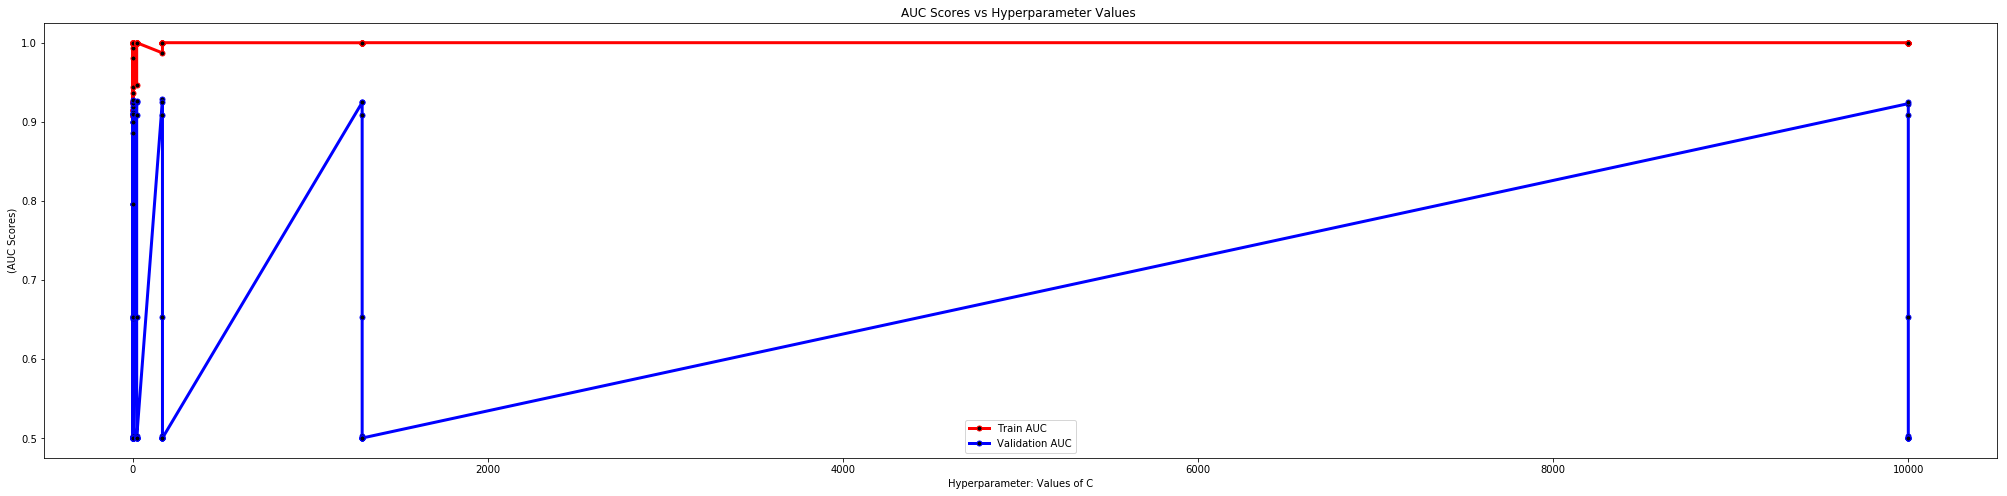

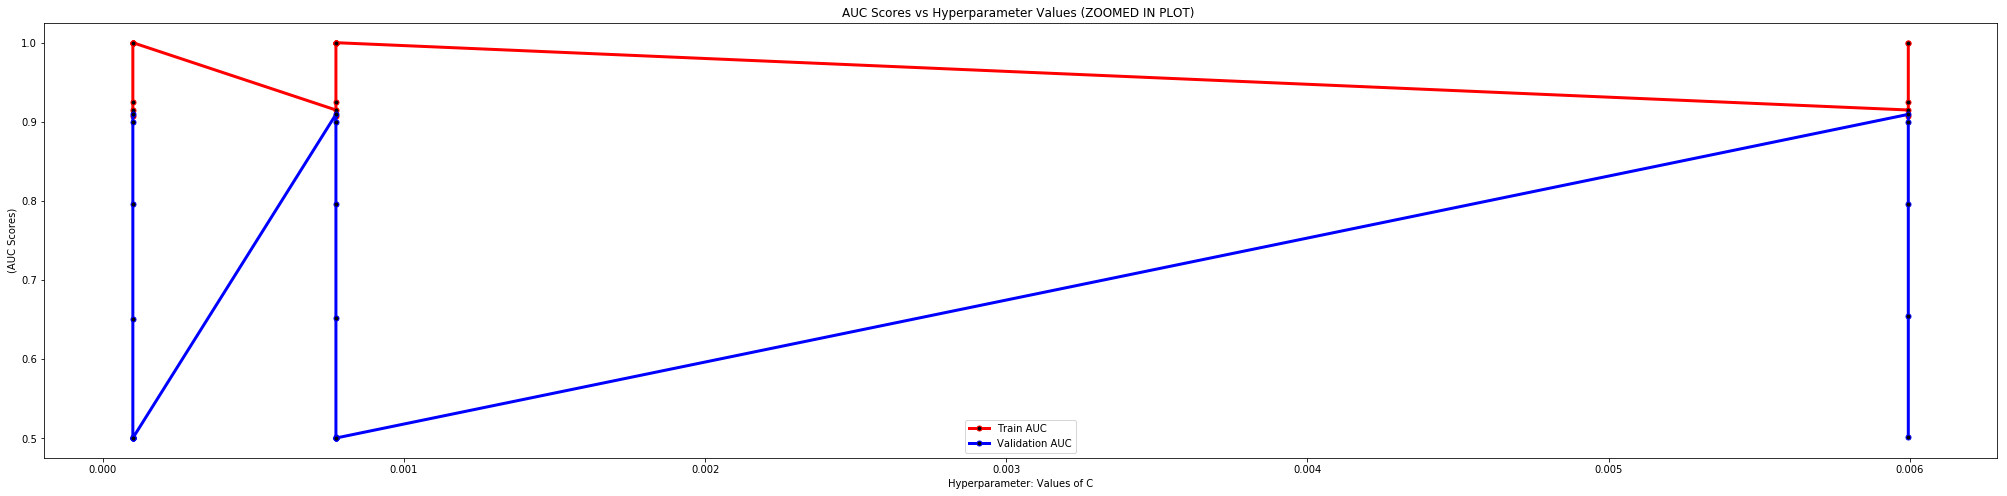

The optimal value of C using l1 regularization is : 0.0001


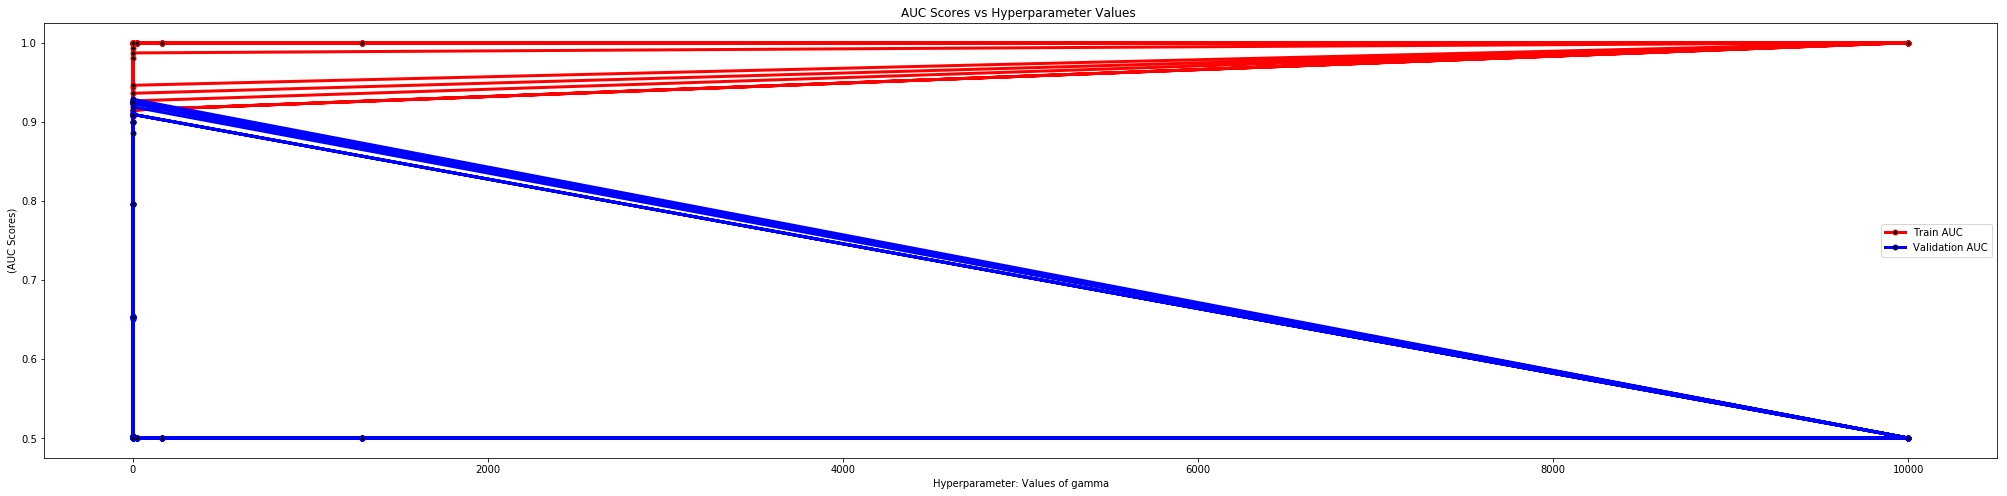

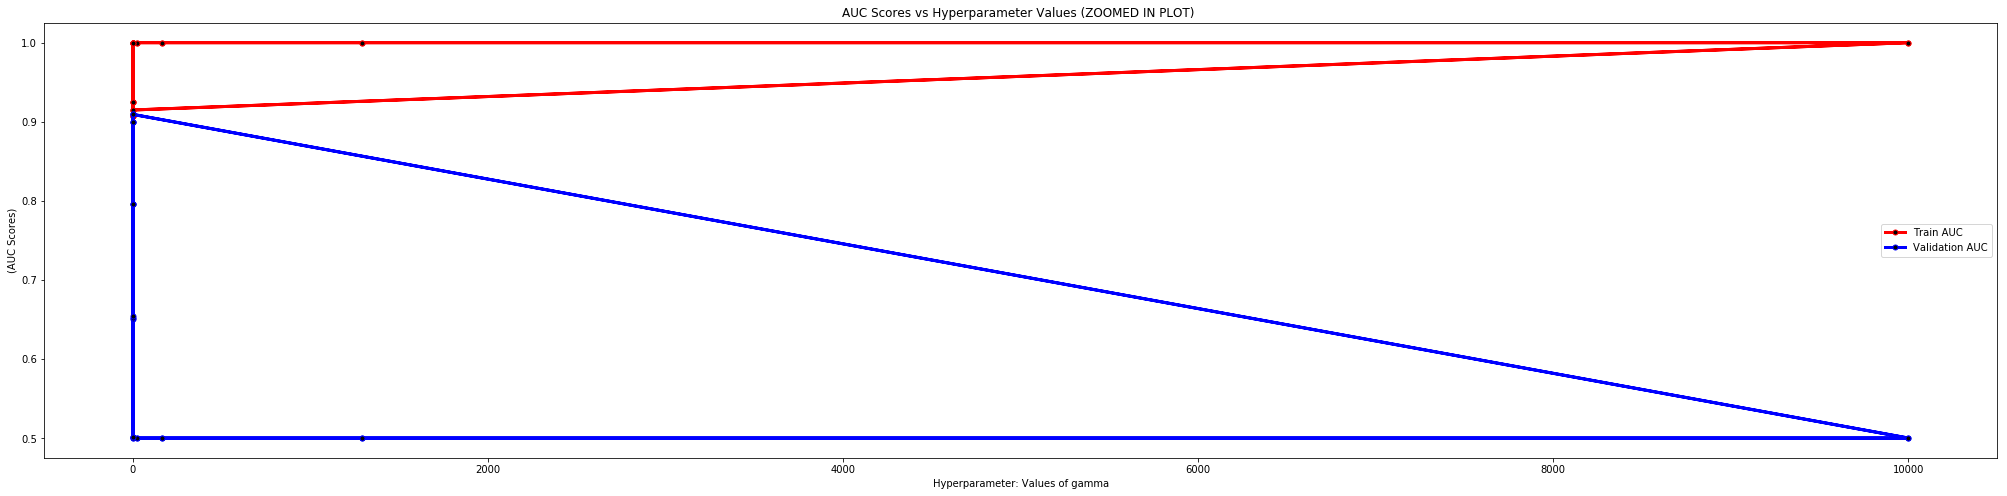


'''PERFORMANCE EVALUATION for AVG-W2V-RBF-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 5000 data points on unseen data for l1 regularization is 4295
Accuracy of the AVG-W2V-RBF-SVM model using l1 regularization on unseen data is 85.9 %
Precision of the AVG-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8527
Recall of the AVG-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8726
F1 score of the AVG-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8625
AUC of the AVG-W2V-RBF-SVM model using l1 regularization on unseen data is 0.9346

Clasification report 
             precision    recall  f1-score   support

          0       0.87      0.85      0.86      2465
          1       0.85      0.87      0.86      2535

avg / total       0.86      0.86      0.86      5000


Of all the reviews that the model has predicted to be positive, 85.0% of them are a

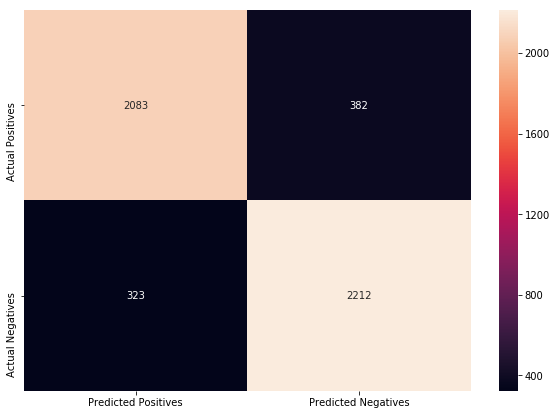

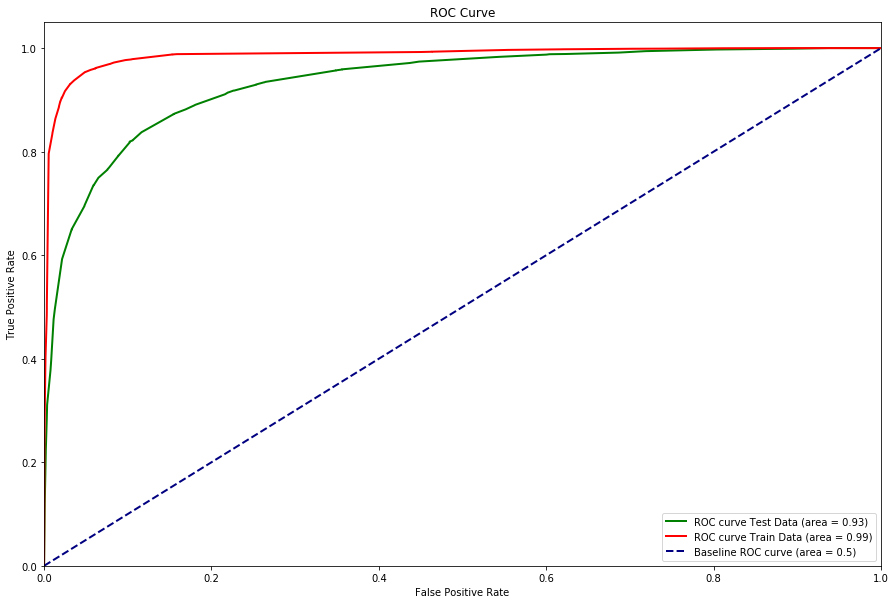

In [8]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)

#Standardize the datasets.
X_train_std = standardize(X_train_vectors)
X_test_std = standardize(X_test_vectors)
X_calib_std = standardize(X_calib_vectors)

trained_classifier_RBF_W2V = RBF_SVM(X_train_std, y_train, X_test_std, y_test, X_calib_std, y_calib, 'l1', "AVG-W2V-RBF-SVM")

### [5.2.4]  Applying RBF SVM on TFIDF W2V + L1 Regularization,<font color='red'> SET 4</font>

100%|██████████| 5000/5000 [00:44<00:00, 112.66it/s]



USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-W2V-RBF-SVM model!
*****************************************************
Best estimator for l1 regularization : 
 SVC(C=166.81005372000558, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Best Score for l1 regularization :  0.9284747218734499
The optimal value of C using l1 regularization is : 166.81005372000558


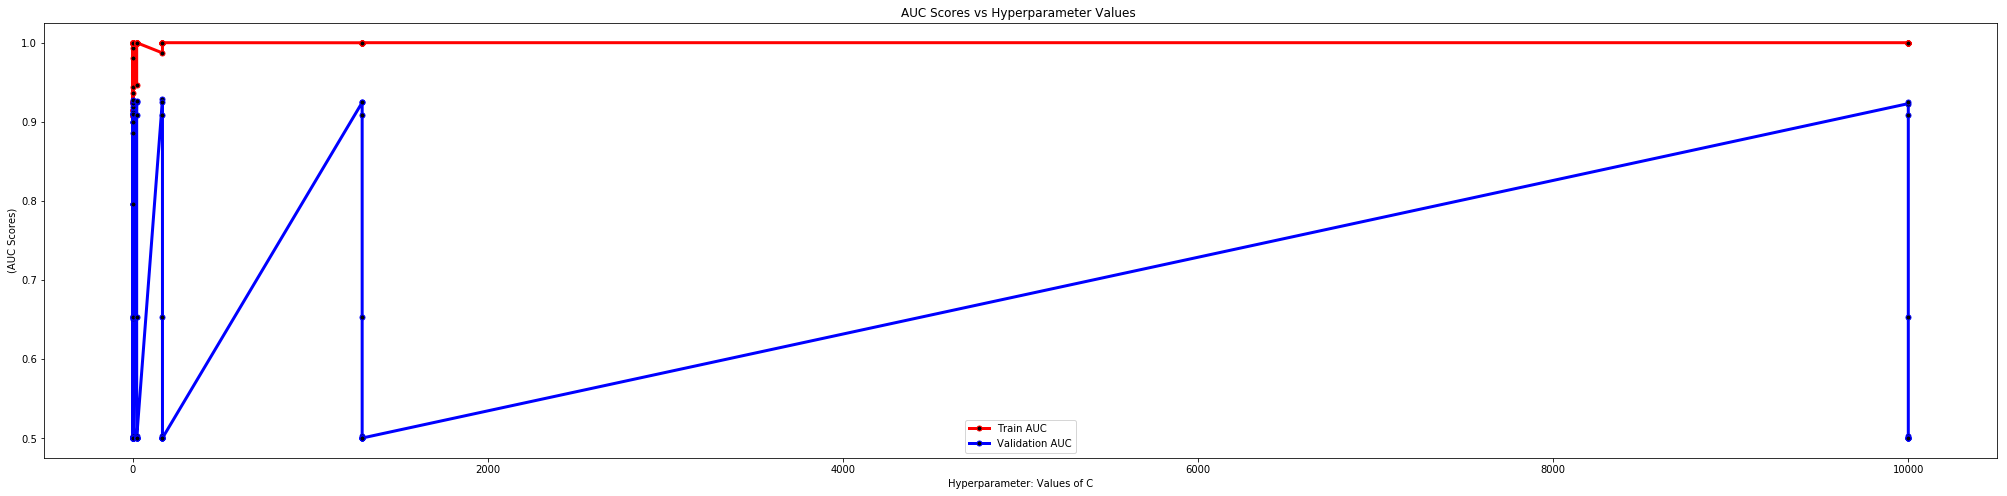

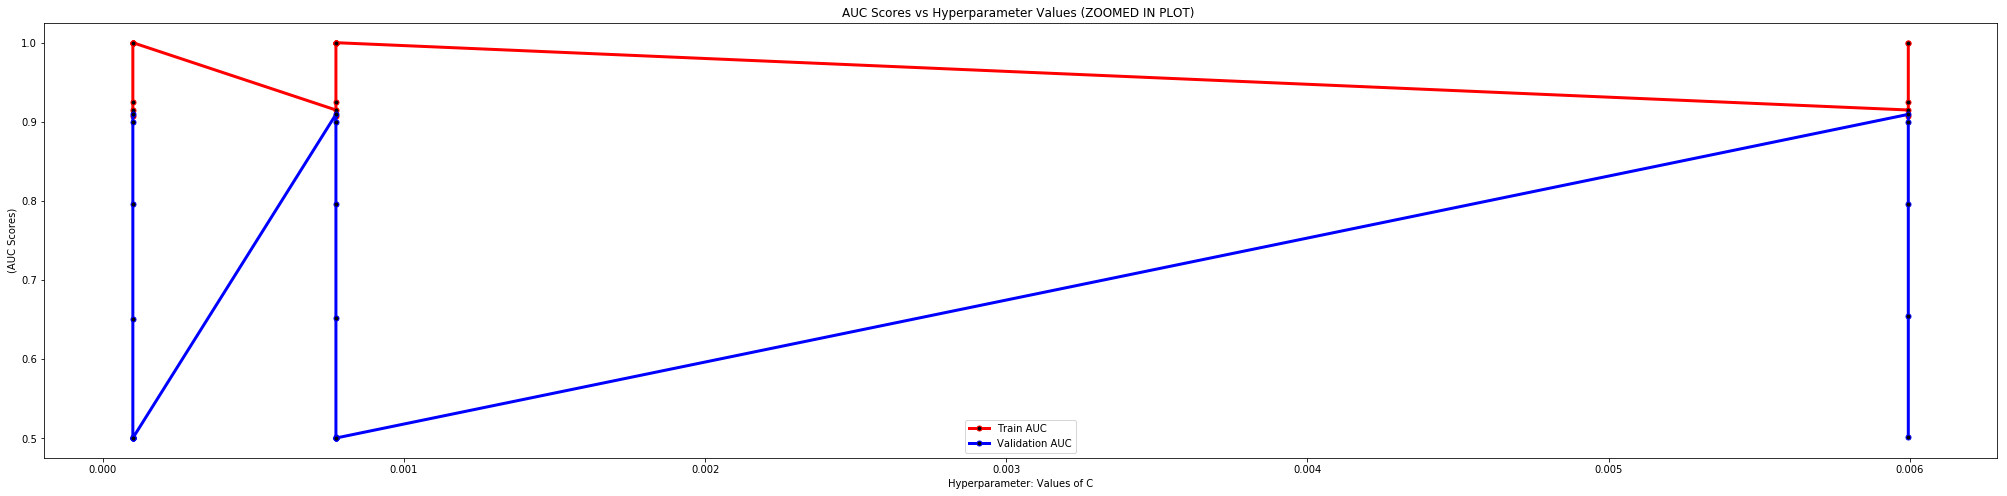

The optimal value of C using l1 regularization is : 0.0001


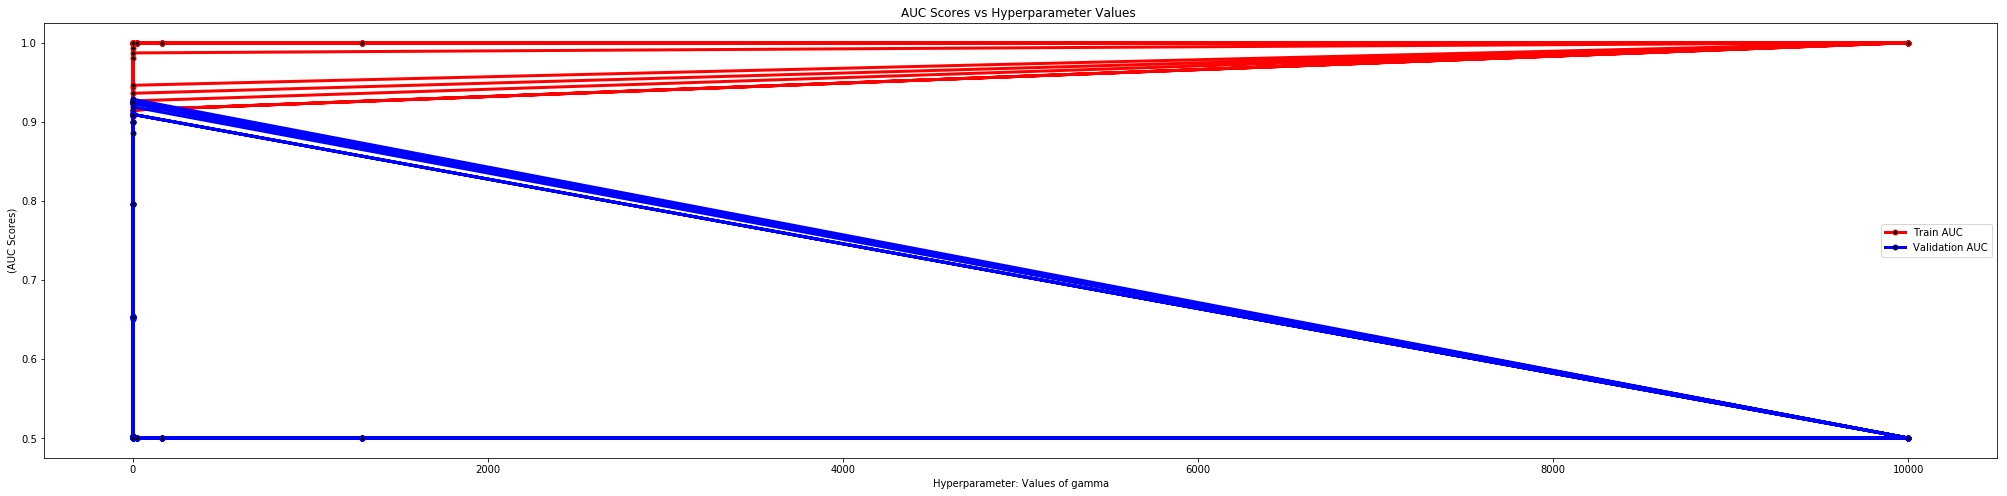

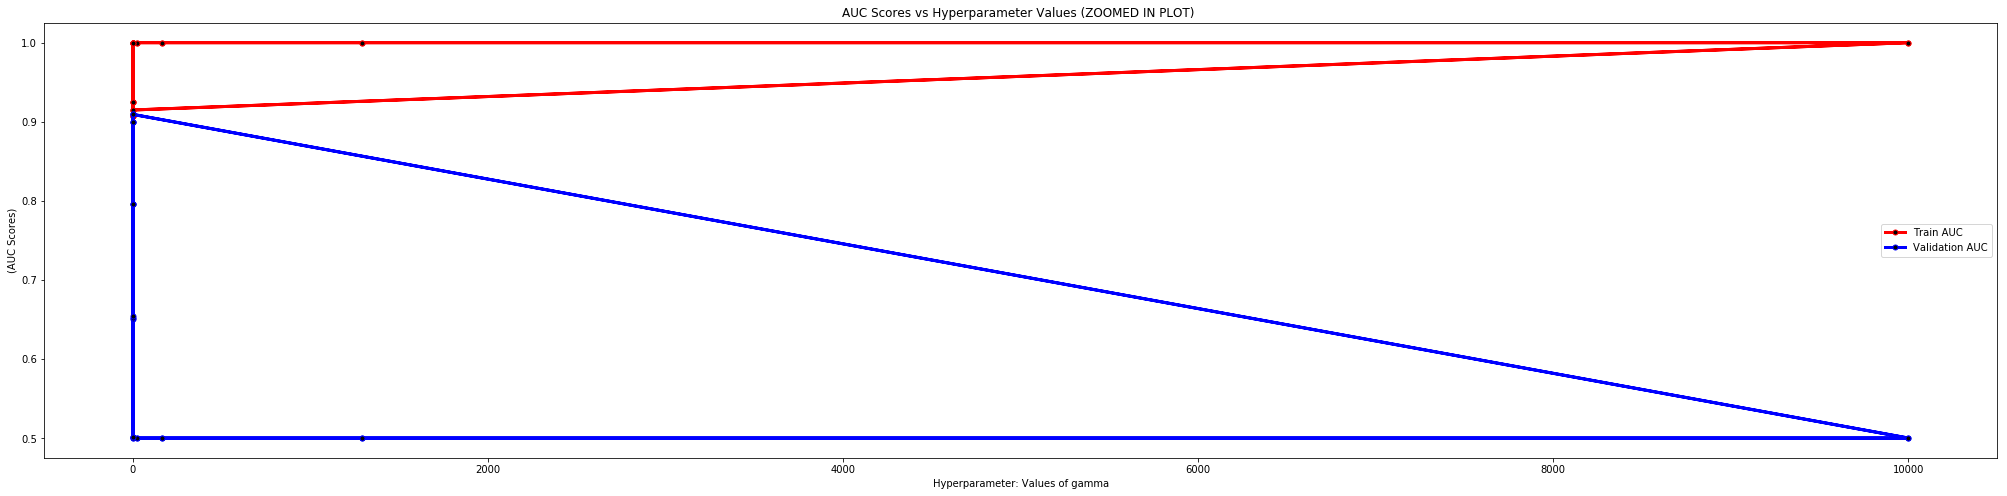


'''PERFORMANCE EVALUATION for TFIDF-W2V-RBF-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 5000 data points on unseen data for l1 regularization is 4295
Accuracy of the TFIDF-W2V-RBF-SVM model using l1 regularization on unseen data is 85.9 %
Precision of the TFIDF-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8527
Recall of the TFIDF-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8726
F1 score of the TFIDF-W2V-RBF-SVM model using l1 regularization on unseen data is 0.8625
AUC of the TFIDF-W2V-RBF-SVM model using l1 regularization on unseen data is 0.9346

Clasification report 
             precision    recall  f1-score   support

          0       0.87      0.85      0.86      2465
          1       0.85      0.87      0.86      2535

avg / total       0.86      0.86      0.86      5000


Of all the reviews that the model has predicted to be positive, 85.0% o

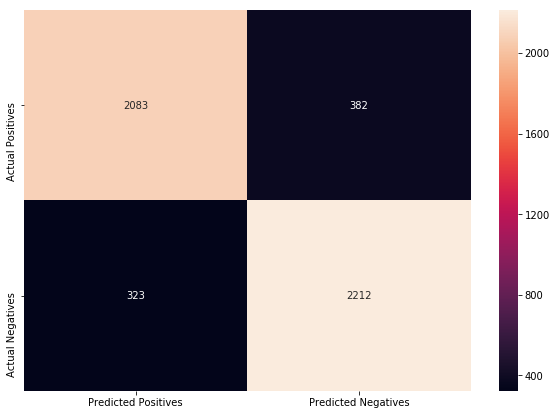

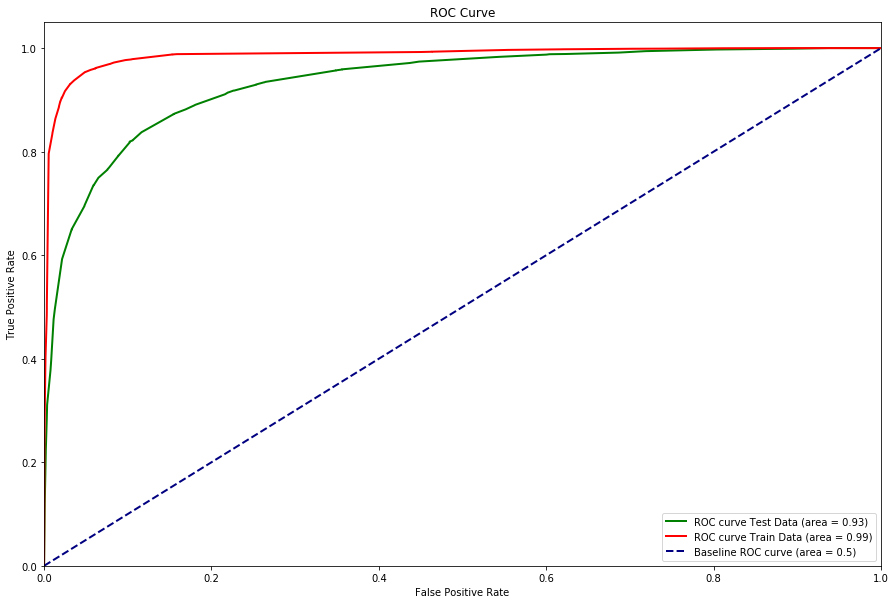

In [9]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

#Standardize the datasets.
X_train_std = standardize(X_train_vectors)
X_test_std = standardize(X_test_vectors)
X_calib_std = standardize(X_calib_vectors)

trained_classifier_RBF_TFIDF_W2V = RBF_SVM(X_train_std, y_train, X_test_std, y_test, X_calib_std, y_calib, 'l1', "TFIDF-W2V-RBF-SVM")

# [6] Conclusions

In [31]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Regularization", " Hyper-Parameter Value (C=)", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_SVMRBF.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+-------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|       Model       | Regularization |  Hyper-Parameter Value (C=) | Accuracy on Unseen data | AUC Score | No. Of accurate predictions |
+-------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|    BOW-RBF-SVM    |       l1       |            2.782            |           85.1          |   0.9286  |             4255            |
|   TFIDF-RBF-SVM   |       l1       |            166.81           |           85.9          |   0.9346  |             4295            |
|  AVG-W2V-RBF-SVM  |       l1       |            166.81           |           85.9          |   0.9346  |             4295            |
| TFIDF-W2V-RBF-SVM |       l1       |            0.0001           |           85.9          |   0.9346  |     

As we can see from the above table, the model with the best AUC score is the linear SVM model applied on TF-IDF feature representations with L2 regularization (AUC: 0.9446, Accuracy: 93.01%). For linear SVM models, we can see that the model tends to perform better for sparse data representations than dense ones. For SVMs with 'RBF' kernel, the model tends to perform the same for both sparse as well as dense data representations, even for a smaller sample size. We have achieved AUC scores of more than 0.93 and accuracy more than 85%, which is fairly good considering the low sample size.